In [1]:
import torch
import torch.nn.functional as F

In [2]:
with open('unique_english_words.txt', 'r') as f:
    words = [word.rstrip() for word in f.readlines()] 

len(words)

948

In [3]:
SPECIAL_TOKEN = '.'

In [4]:
unique_symbols = set(list(''.join(words)))
unique_symbols.add(SPECIAL_TOKEN)
print(f'Num of unique symbols: {len(unique_symbols)}')

stoi = {s: i for i, s in enumerate(unique_symbols)}
itos = {i: s for s, i in stoi.items()}

Num of unique symbols: 28


## Split all words into **train**, **val** and **test** datasets

Why split? We can train a very big model with thousands params and eventually get extrimelly low training loss. But it doesn't mean that our model is so good. It means it memorize our train data and performs well only on this data. If we evaluate it on unseen dataset the loss is likely to be high. And if we try to genearte something new (like new english words in this case) we probably fail because the only data we'll be able to generate is only data which was seen by model.
<br> So to train a good model we need evaluate it not only on train (seen) data but on val (unseen) data as well.

In [5]:
import random

random.seed(23)
random.shuffle(words)

train_split = int(0.8 * len(words))
val_split = int(0.9 * len(words))

train_words = words[:train_split]
val_words = words[train_split:val_split]
test_words = words[val_split:]

print('train:', len(train_words))
print('val:', len(val_words))
print('test:', len(test_words))

train: 758
val: 95
test: 95


## Building a dataset

In [6]:
## Example for a couple of words

block_size = 3 # how many characters we are gonna use to predict the next one
for word in words[:3]:
    word = SPECIAL_TOKEN * block_size + word + SPECIAL_TOKEN
    for i in range(block_size, len(word)):
        context = word[i - block_size:i]
        ch_to_predict = word[i]
        print(context, '-->', ch_to_predict)


... --> m
..m --> e
.me --> l
mel --> d
eld --> r
ldr --> o
dro --> p
rop --> .
... --> c
..c --> y
.cy --> b
cyb --> e
ybe --> r
ber --> s
ers --> q
rsq --> u
squ --> a
qua --> t
uat --> t
att --> i
tti --> n
tin --> g
ing --> .
... --> d
..d --> i
.di --> s
dis --> e
ise --> m
sem --> b
emb --> o
mbo --> g
bog --> u
ogu --> e
gue --> .


In [7]:
# build dataset on full data
def build_dataset(words):
    block_size = 3 # how many characters we are gonna use to predict the next one
    X = []
    y = []
    
    for word in words:
        word = SPECIAL_TOKEN * block_size + word + SPECIAL_TOKEN
        for i in range(block_size, len(word)):
            context = word[i - block_size:i]
            ch_to_predict = word[i]
    
            X.append([stoi[ch] for ch in context])
            y.append(stoi[ch_to_predict])
    
    X = torch.tensor(X)
    y = torch.tensor(y)

    return X, y

In [8]:
X_train, y_train = build_dataset(train_words)
X_val, y_val = build_dataset(val_words)
X_test, y_test = build_dataset(test_words)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([7182, 3]) torch.Size([7182])
torch.Size([904, 3]) torch.Size([904])
torch.Size([931, 3]) torch.Size([931])


## Model

In [9]:
# build a look up table C
# where each symbol is represented as n-dim vector
# (lets consider 2-dim vectors for beginning)

vector_dim = 2
C = torch.randn((len(unique_symbols), vector_dim))
C.shape

torch.Size([28, 2])

In [10]:
emb = C[X_train]
emb.shape

torch.Size([7182, 3, 2])

In [11]:
### ----------------params initialization----------------
# geneartor for reproducibility
g = torch.Generator().manual_seed(23)

hidden_layer_size = 100

### params for a 2 layers NN
# hidden layer
W1 = torch.randn((block_size * vector_dim, hidden_layer_size), generator = g)
b1 = torch.randn((hidden_layer_size,), generator = g)

# output layer
W2 = torch.randn((hidden_layer_size, len(unique_symbols)), generator = g)
b2 = torch.randn((len(unique_symbols),), generator = g)

params = [C, W1, b1, W2, b2]
for p in params:
    p.requires_grad = True

In [12]:
n_iter = 50_000

losses_train = []
losses_val = []
for i in range(n_iter):

    # to speed up calculations instead of using the whole dataset
    # lets use just part of it for each iteration (mini batch)
    batch_size = 64
    rand_indecies = torch.randint(0, X_train.shape[0], (batch_size, ))

    # ---------------forward pass---------------

    emb = C[X_train[rand_indecies, ...]] # shape: [batch_size, block_size, vector_dim]
    
    #----the first layer----
    # 'emb' tensor has shape [n, block_size, vector_dim]
    # but 'W1' has size [block_size * vector_dim, layer_1_size]
    # so we can multiply these tensors we can use torch.tensor.view() method
    # which 'Returns a new tensor with the same data as the self tensor but of a different shape.'
    
    # h = tanh(emb @ W1 + b1)
    h = torch.tanh(emb.view(-1, block_size * vector_dim) @ W1 + b1)
    
    #----the second (output) layer ----
    logits = h @ W2 + b2
    
    # softmax
    # counts = logits.exp()
    # probs = counts / counts.sum(dim = 1, keepdim = True)
    
    #----loss----
    # log_likekihood = probs[torch.arange(probs.shape[0]), y].log().mean()
    # neg_log_likelihood = -log_likekihood
    # neg_log_likelihood
    
    ## instead of line-by-line implementation of softmax
    # it is better to use already implemented functions from torch lib
    # (which are usually more efficient)
    loss = F.cross_entropy(logits, y_train[rand_indecies])
    losses_train.append(loss.item())

    # val loss
    emb_val = C[X_val]
    h_val = torch.tanh(emb_val.view(-1, block_size * vector_dim) @ W1 + b1)
    logits_val = h_val @ W2 + b2
    loss_val = F.cross_entropy(logits_val, y_val)
    losses_val.append(loss_val.item())
    
    # ---------------backward pass---------------
    for p in params:
        p.grad = None
    
    loss.backward()
    
    # update
    lr = 0.1 if i < 30_000 else 0.01
    for p in params:
        p.data += -lr * p.grad

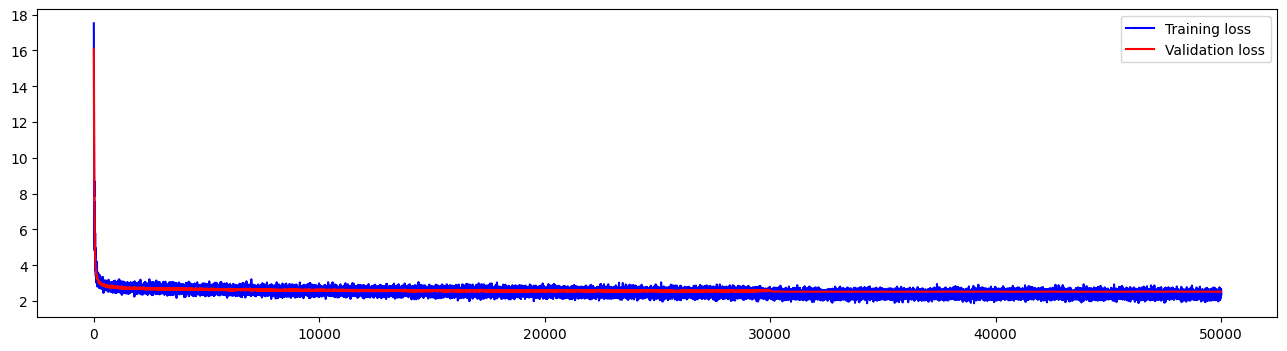

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4))
plt.plot(range(n_iter), losses_train, 'b', label = 'Training loss')
plt.plot(range(n_iter), losses_val, 'r', label = 'Validation loss')
plt.legend()

In [14]:
# training losss

emb = C[X_train]
h = torch.tanh(emb.view(-1, block_size * vector_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train)
loss

tensor(2.3690, grad_fn=<NllLossBackward0>)

In [15]:
# val losss

emb = C[X_val]
h = torch.tanh(emb.view(-1, block_size * vector_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_val)
loss

tensor(2.5204, grad_fn=<NllLossBackward0>)

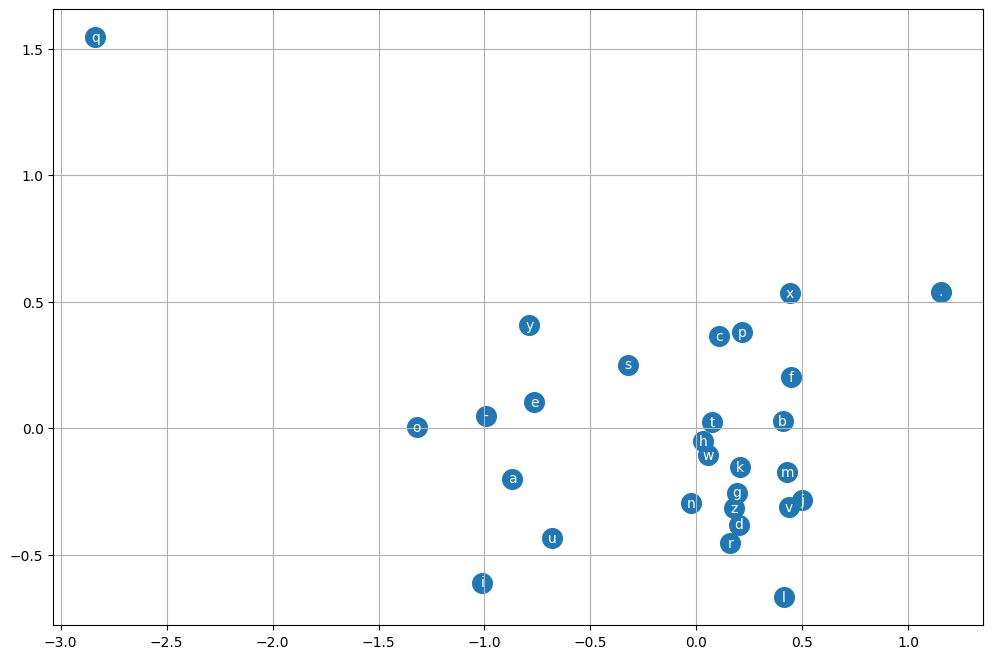

In [16]:
plt.figure(figsize=(12,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

## Predictions

In [17]:
g = torch.Generator().manual_seed(23)

# let's generate some new unique English words!
for i in range(20):
    word = list(SPECIAL_TOKEN * block_size)
    while True:
        context = word[-block_size:]
        context_idx = torch.tensor([stoi[ch] for ch in context])
        
        emb = C[context_idx.view(1, -1)]
        
        h = torch.tanh(emb.view(-1, block_size * vector_dim) @ W1 + b1)
        logits = h @ W2 + b2

        # apply softmax
        counts = logits.exp()
        probs = counts / counts.sum(dim = 1, keepdim = True)

        idx = torch.multinomial(probs, num_samples = 1, replacement = True, generator = g).item()
        if idx == stoi[SPECIAL_TOKEN]: # if we meet special token - it is the end of the word!
            break  
        word.append(itos[idx])

    print(''.join(word))

...wiu
...bib
...daffe
...zecfetobfanigacollrerie
...seut
...jery
...peletosaer
...prix
...pethenkucent
...hurous
...lambus
...reosk
...avmokumotiteteoury
...chion
...imac
...sukeria
...wargouty
...plasdinamitatitange
...bur
...eny


## Overfitting!

In [18]:
def build_model(vector_dim, hidden_layer_size, n_iter = 1_000):
    C = torch.randn((len(unique_symbols), vector_dim))

    ### ----------------params initialization----------------
    g = torch.Generator().manual_seed(23)
    W1 = torch.randn((block_size * vector_dim, hidden_layer_size), generator = g)
    b1 = torch.randn((hidden_layer_size,), generator = g)
    W2 = torch.randn((hidden_layer_size, len(unique_symbols)), generator = g)
    b2 = torch.randn((len(unique_symbols),), generator = g)
    
    params = [C, W1, b1, W2, b2]
    for p in params:
        p.requires_grad = True

    losses_train = []
    losses_val = []
    for i in range(n_iter):
    
        batch_size = 64
        rand_indecies = torch.randint(0, X_train.shape[0], (batch_size, ))
    
        emb = C[X_train[rand_indecies, ...]] # shape: [batch_size, block_size, vector_dim]
        h = torch.tanh(emb.view(-1, block_size * vector_dim) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, y_train[rand_indecies])
        losses_train.append(loss.item())
    
        # val loss
        emb_val = C[X_val]
        h_val = torch.tanh(emb_val.view(-1, block_size * vector_dim) @ W1 + b1)
        logits_val = h_val @ W2 + b2
        loss_val = F.cross_entropy(logits_val, y_val)
        losses_val.append(loss_val.item())
        
        # ---------------backward pass---------------
        for p in params:
            p.grad = None
        
        loss.backward()
        
        # update
        for p in params:
            p.data += -0.1 * p.grad
    
    
    plt.figure(figsize=(16, 4))
    plt.plot(range(n_iter), losses_train, 'b', label = 'Training loss')
    plt.plot(range(n_iter), losses_val, 'r', label = 'Validation loss')
    plt.legend()

    return params

### Increase dimentionality of vectors which represent symbols

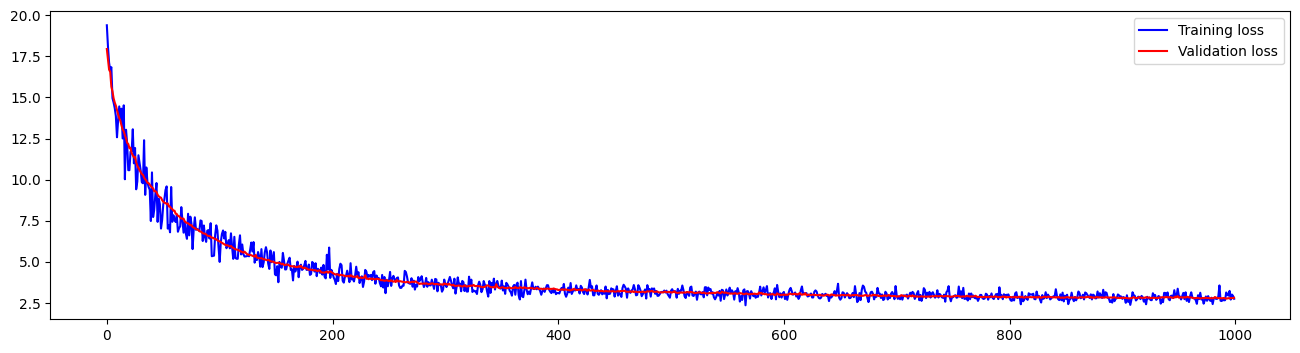

In [19]:
params = build_model(vector_dim = 5, hidden_layer_size = 100)

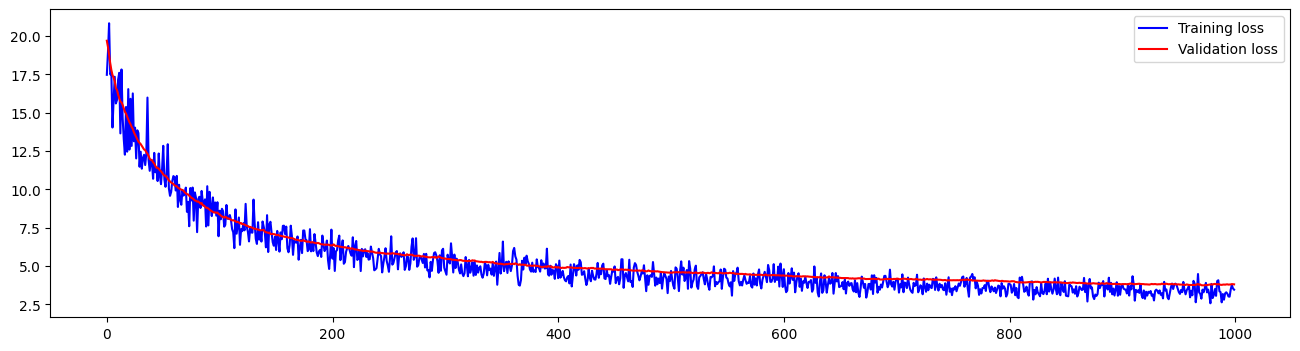

In [20]:
params = build_model(vector_dim = 10, hidden_layer_size = 100)

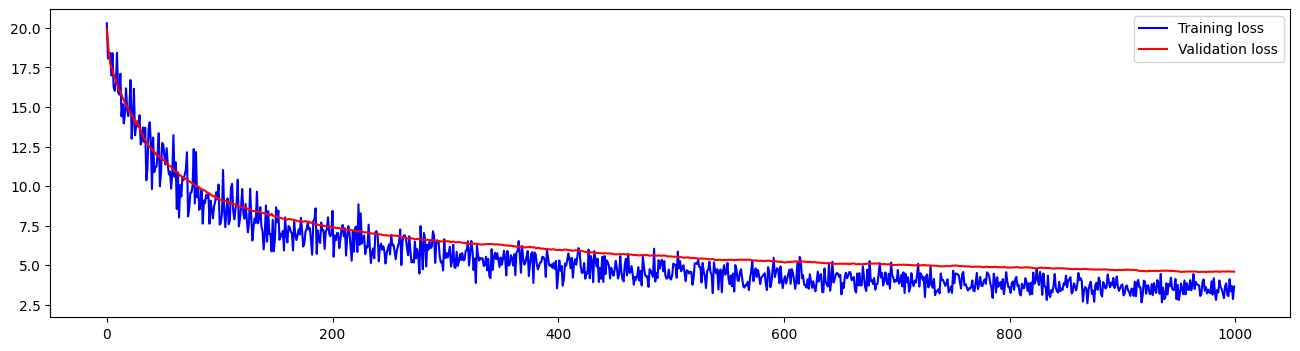

In [21]:
params = build_model(vector_dim = 20, hidden_layer_size = 100)

In [22]:
# training loss

emb = params[0][X_train]
h = torch.tanh(emb.view(-1, block_size * 20) @ params[1] + params[2])
logits = h @ params[3] + params[4]
loss = F.cross_entropy(logits, y_train)
loss.item()

3.482123851776123

In [23]:
# val losss

emb = params[0][X_val]
h = torch.tanh(emb.view(-1, block_size * 20) @ params[1] + params[2])
logits = h @ params[3] + params[4]
loss = F.cross_entropy(logits, y_val)
loss.item()

4.5925164222717285

### Increase num of neurons in hidden layer

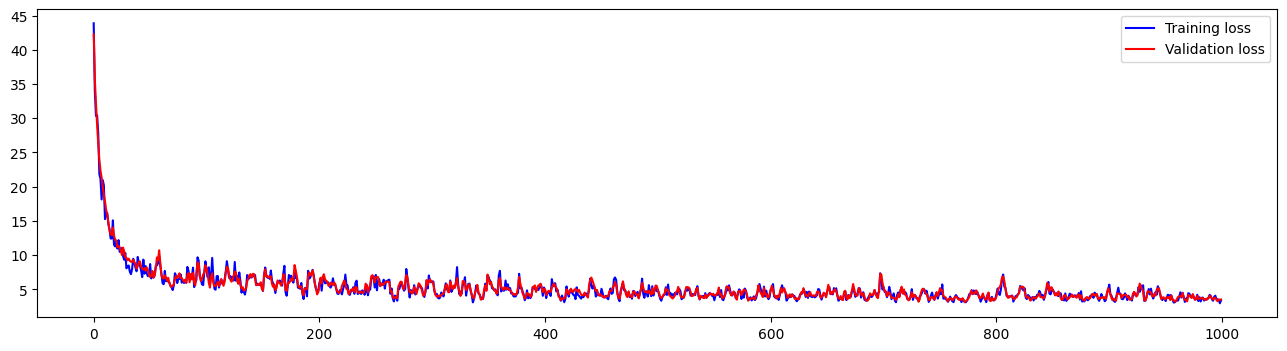

In [24]:
params = build_model(vector_dim = 2, hidden_layer_size = 500)

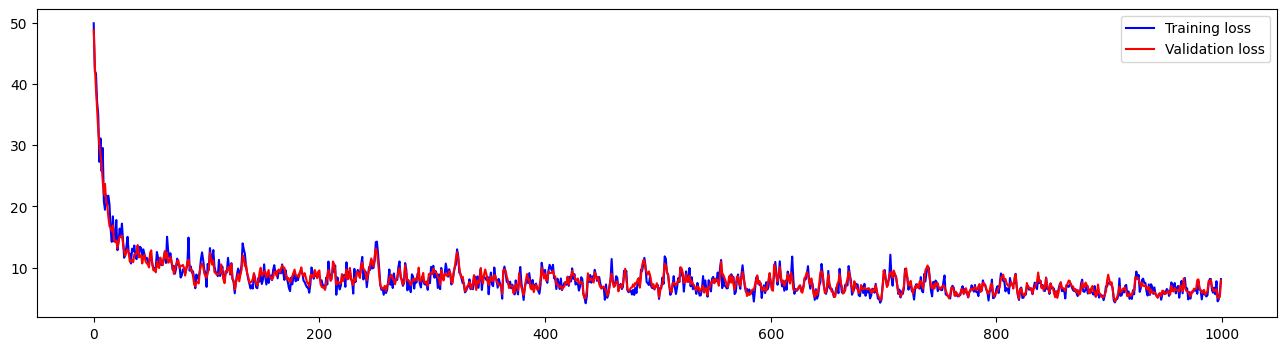

In [25]:
params = build_model(vector_dim = 2, hidden_layer_size = 1000)

### Very big model

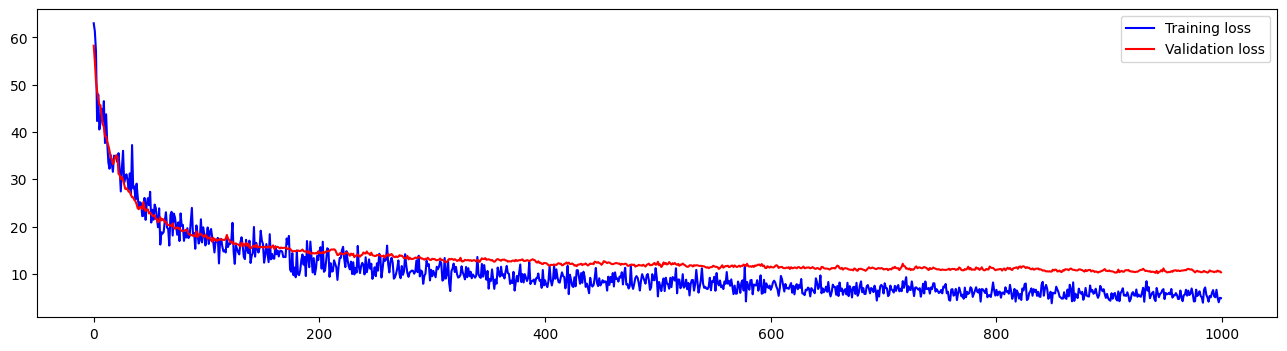

In [26]:
params = build_model(vector_dim = 10, hidden_layer_size = 1000)

In [28]:
# training loss

emb = params[0][X_train]
h = torch.tanh(emb.view(-1, block_size * 10) @ params[1] + params[2])
logits = h @ params[3] + params[4]
loss = F.cross_entropy(logits, y_train)
loss.item()

5.143712997436523

In [29]:
# val losss

emb = params[0][X_val]
h = torch.tanh(emb.view(-1, block_size * 10) @ params[1] + params[2])
logits = h @ params[3] + params[4]
loss = F.cross_entropy(logits, y_val)
loss.item()

10.313663482666016